In [99]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR



import numpy as np
import pandas as pd
from utils import progress_bar

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

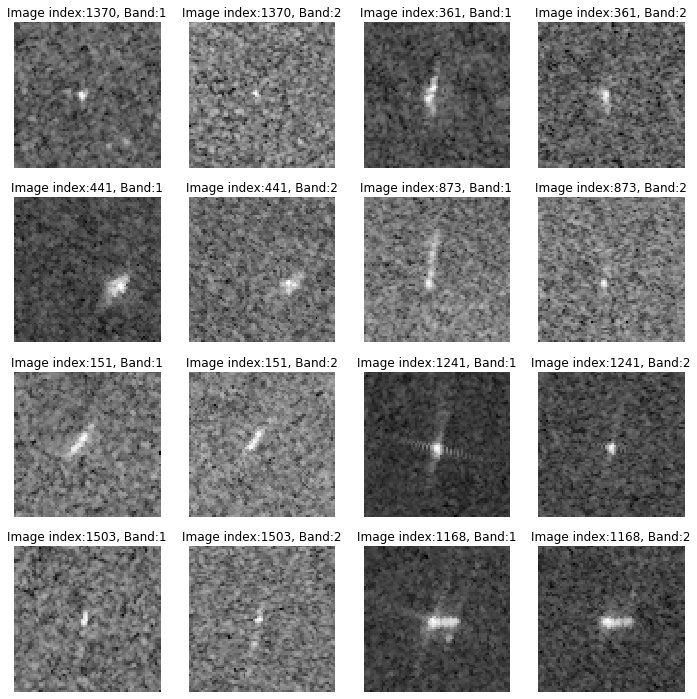

In [22]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [91]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(dtype)
        self.transform= transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=1).copy()
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=2).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [92]:
train_index=list(range(1300)) 
val_index= list(range(1300,1604))
train_X[train_index].shape

train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size = 64, num_workers=1, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=1)

In [98]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
for i in train_loader:
    print(i[0][0].std())
    break

0.5487609502208006


In [103]:
resnet101 = models.resnet101(num_classes=2)

criterion = nn.BCELoss()

#Adam does not perform so good here
optimizer = optim.SGD(resnet101.parameters(), lr=0.1, momentum=0.9, weight_decay=8e-4, nesterov= True)
scheduler = MultiStepLR(optimizer, [60,90], gamma=0.1)

if use_cuda:
    criterion.cuda()
    resnet101.cuda()

In [ ]:
def train(net, epoch):
    global train_data
    best_acc =0
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist

    for i in range(epoch):
        print('This is epoch:{}'.format(i+1))
        total= 0
        correct=0
        scheduler.step()
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss.cpu().data[0], 100.*correct/total, correct, total))
            if j % 50==0:
                loss_hist.append(loss.cpu().data[0])
            
        train_acc_hist.append(100.*correct/total)
        if i %1 == 0:
            acc = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                torch.save(net.state_dict(), 'resnet101.pth')
                
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss= 0
    for val_x, val_y in val_load:
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        #print(out.size())
        correct += (torch.max(out,1)[1]==y).sum().data[0]
        total += out.size()[0]
        progress_bar(j, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss.cpu().data[0], 100.*correct/total, correct, total))
    acc =  (correct*100.0)/total
    return acc

train(resnet101, epoch=100)